In [1]:
from casadi import *
import numpy as np
import matplotlib.pyplot as plt
import os 
import sys

from dyn_sys_eq.derive import derive
from contextlib import contextmanager

from contextlib import redirect_stdout
import io 

# run "%pip install progressbar2" in a cell to install package
import progressbar
from viz.draw_class import Visualizer

# Load system equations
The system is loaded. It is defined as suggested by the paper "Energy and Passivity Based Control of the Double
Inverted Pendulum on a Cart". The Euler-Lagrange equations are defined accordingly.

The state vector is defined as follows:
\begin{align}
    x_1 &= x_c, \\
    x_2 &=  \phi_1,  \\
    x_3 &= \phi_2, \\
    x_4 &= \dot{x_c}, \\
    x_5 &=  \dot{\phi_1},\\
    x_6 &= \dot{\phi_2}
\end{align}

or in vector form:

\begin{align}
\vec{x} = \begin{pmatrix} x_c \\ \phi_1 \\ \phi_2 \\ \dot{x_c} \\ \dot{\phi_1} \\ \dot{\phi_2} \end{pmatrix}
\end{align}

The input consists only of the applied force in the range of $-4N \leq F \leq 4N$, and is therefor one-dimensional. As seen above the state vector is of the order six. Therefor we define:

\begin{align}
    n_x = 6 \\
    n_u = 1
\end{align}


In [2]:
nx = 6
nu = 1

x = SX.sym("x", nx)
u = SX.sym("u", nu)

# get system of first order ODEs
xdot = derive(x, u)

# crate system function from first order ODEs
system = Function("system", [x, u], [xdot])

# Global Paramters
We set paramters:

timestep: $dt = 0.02$ 

simulation steps: $N_{sim} = 1000$ 

prediction horizon: $N = 60$ 

initial state: $x_0 = \begin{pmatrix} 0 \\ -\pi \\ -\pi \\ 0 \\ 0 \\ 0   \end{pmatrix}$

collocation degree: $K=3$

In [3]:
# Timestep 
dt = 0.02
# Define the total steps to simulate
N_sim = 1000

# prediction horizon
N = 50

# collocation degree
K = 3

# inital position 
x_0 = np.array([0,  -np.pi, -np.pi, 0, 0, 0]).reshape(nx,1)

# init visualizer object
viz = Visualizer()


# Obstacle
We will intruduce obstacles to our problem. For ease of use these will be defined as circles. Therefor our obstacles are described by their midpoint and radius. In addition we introduce a flag to toggle the obstacle on and off.

Here we will insert one obstacle at $(2, 1.3)$ with radius 0.6.

In [4]:
# obstacle 
obstacle = True
obs_pos = (2, 1.3)
obs_rad = 0.6

# Init Sundials ODE Solver
As seen in Exercise 04, we use the Sundials ODE Solver to simulate the system.

In [5]:
# dict for options and ode needed for solver object
ode = {'x': x, 'ode': xdot, 'p': u}
opts = {'tf': dt}

# Create the solver object.
ode_solver = integrator('F', 'idas', ode, opts)


# Orthoganal Collocation 
For the collocation we obtain the collocation points using the Legrende polynomial. 
To calculate those points we define the Lagrange interpolation polynomial (see Ex. 04 / Task 03) and a function to get the evaluated polynomial. 

In [6]:
# collocation points (excluding 0)
tau_col = collocation_points(K,'legendre')

# collocation points (including 0)
tau_col = [0]+tau_col

tau = SX.sym('tau')


In [7]:
# Return Lagrange basis polynomial for list of collocation points
def L(tau_col, tau, j):
    l = 1
    for k in range(len(tau_col)):
        if k!=j:
            l *= (tau-tau_col[k])/(tau_col[j]-tau_col[k]) 
    return l

def LInt(tau_col, tau, j):
    z = np.poly1d([1])
    for k in range(len(tau_col)):
        if k!=j:
            z *= np.poly1d([1, -tau_col[k]]) / (tau_col[j]-tau_col[k])   
    z_int = np.polyint(z)
    return np.sum(z_int.coef)


Calculate the orthogonal collocation coefficients $a_{j,k}$ and store them in a matrix $A$. These are the collocation constraints.

In [8]:

tau = SX.sym('tau')

A = np.zeros((K+1,K+1))

for j in range(K+1):
    dLj = gradient(L(tau_col, tau, j), tau)
    dLj_fcn = Function('dLj_fcn', [tau], [dLj])
    for k in range(K+1):
        A[j,k] = dLj_fcn(tau_col[k])

Caculate the contuinity coeffcient $d_j$ and store them in the vector $D$. We need these to make sure that a given final state of a finite element equals then start state of the following. Additionally calculate coefficients of integrated Lagrange Polynom and store them in $B$

In [9]:
D = np.zeros((K+1,1))
B = np.zeros((K+1,1)) # Coefficients of quadrature eq

for j in range(K+1):
    Lj = L(tau_col, tau, j)
    Lj_fcn = Function('Lj', [tau], [Lj])
    D[j] = Lj_fcn(1)
    
    L_int_j = LInt(tau_col, tau, j)
    B[j] = L_int_j


## Integrate with orthogonal collaction 

# Define the MPC optimazation problem

use quadratic cost function 
$$l(x_{i,0},u_i) = x_{i,0}^T Q x_{i,0} + u_i^T R u_i $$

where Q and R are positive definite diagonal matrices. 
For the terminal cost we have a slightly altered expression:

$$ m(x_{N+1,0}) = x_{N+1,0}^T P x_{N+1,0}, $$ 

For simplicity we assume $P=Q$.

## Define Constrains
Most important are the constraints for the input force. As mentioned before they are set to $\pm 4N$. We dont have specific constraints for the state vector. We will limit the cart position to $x$ values between $-6$ and $6$ which shall reduce the amount of cart movement. Since we dont want to put any constraints on the periodic pole angles we set those limits to $\pm \infty$ respectively. For the remaining states we will choose a constraint of  $\pm 30$, which is choosen abitrarily, although it should not be to small so it will not infulence the result to much or even lead to a infeasible problem. 

In [10]:
# state constraints
lb_x = -30*np.ones((nx,1))
lb_x[0] = -6
lb_x[1] = -np.inf
lb_x[2] = -np.inf


ub_x = 30*np.ones((nx,1))
ub_x[0] = 6
ub_x[1] = np.inf
ub_x[2] = np.inf

# input constraints
lb_u = -4*np.ones((nu,1))
ub_u = 4*np.ones((nu,1))


## Cost function
We implemented a weighted energy and state based Cost function.
For the stage as well as the terminal cost in terms of state costs the carts position is most important. The state cost will mostly be used to get the cart in the desired location. 
The cart position is weihgted more for the terminal cost, since the cart should be on target at the end and its not as bad if it differes from this position in the process.

For the pole angles we need to take into account its periodicity. To do so we will set the stage weights for it to 0 and redefine it seperatly later.

The pendulum is fully errect for pole angles of $2\cdot\pi \cdot k$ with $k \in \mathbb{Z}$. To reflect this in our cost function we use following equation:

$J_{phi1,2} =\sin(0.5\cdot x_1)^2 + \sin(0.5\cdot x_2)^2$

This term can simply be added to the Cost function. This angle cost function will also be weighted. As for the cart position the angle should be optimazied in the end and therefor our terminal weight will be higher. In the same manner we add weights to the Energy cost.

We introduce the following cost weights:

| Cost variable |  |
| :- | :- |
| $w_{stage,phi}$ | Weight for stage cost of angles |
| $w_{terminal,phi}$ | Weight for terminal cost of angles |     
| $Q_{stage}$ | Weight for stage cost of states |   
| $Q_{terminal}$ | Weight for terminal cost of states |     
| $w_{stage,energy}$ | Weight for stage cost of energies |     
| $w_{terminal,energy}$ | Weight for terminal cost of energies |       



In [11]:
Q_stage = np.diag([10,0,0,1,1,1])

Q_term = np.diag([100,0,0,1,1,1])

#weights angle tracking
w_stage_phi = 1
w_term_phi = 10

#weights energy 
w_stage_energy = 1
w_term_energy = 10

R = 1

We define:


| Variable     |  |
| :- | :- |
| $l_{1,2} = 0.25$ | Distance from pole joint to pole center of mass |
| $L_{1,2} = 2 \cdot l_{1,2} = 0.5$ | Length of pole |
| $J_{1,2} = \frac{1}{12} \cdot m_{1,2} \cdot L_{1,2}^2$ | Inertias of pole joints with respect to the center of mass |


With our states the kinetic energy is defined as follows:

\begin{align}
E_{kin,1} &= \frac{1}{2}\cdot m\cdot x_3^2 \\
E_{kin,2} &= \frac{1}{2}\cdot m1\cdot ((x_3 + l_1\cdot x_4 \cdot \cos(x_1))^2 + (l_1\cdot x_4 \cdot \sin(x_1))^ 2) + 1/2\cdot J_1\cdot x_4^2 \\
E_{kin,3} &= \frac{1}{2}\cdot m_2\cdot ((x_3 + L_1\cdot x_4 \cdot \cos(x_1) + l_2\cdot x_5 \cdot \cos(x_2))^2 + (L_1\cdot x_4\cdot \sin(x_1) + l_2\cdot x_5\cdot sin(x_2))^2) + 1/2\cdot J_2\cdot x_4^2 \\
E_{kin} &= E_{kin,1} + E_{kin,2} + E_{kin,3} 
\end{align}


To make it more readable the kinetic energy is shown seperatly for each pole joint. Then we calculate the potential energy as well:


\begin{align}
E_{pot} = m_1\cdot g\cdot l_1\cdot \cos(x_1) + m_2\cdot g\cdot (L_1\cdot \cos(x_1) + l_2\cdot \cos(x_2))
\end{align}


For the stage cost we want to maximize the total energy and for the terminal cost we want to maximizie potential energy and minimize kinetic energy. In addition our state based cost function has to be minimal (this mainly means the cart position must be near target).

To take the states into account we substract the target state from the state vector which is used to calculate those energies. So we get new states:

\begin{align}  
\vec{x}_{new} = \vec{x} - \vec{x}_{target}
\end{align}

We can calculate the total energy by adding potential and kinetic energy:

\begin{align}
E_{total} = E_{kin} + E_{pot}
\end{align}

The total potential energy in the target space is then:

\begin{align}
E_{pot, target} = E_{pot} \big|_{\phi_1 = \phi_2 = 0} =  m_1 \cdot g \cdot l_1 + m_2 \cdot g \cdot (L_1 + l_2)
\end{align}

The total energy in the target state is then simply:

\begin{align}
E_{target} = 0 + E_{pot} \big|_{\phi_1 = \phi_2 = 0} = E_{pot, target}
\end{align}

The kinetic energy shall be zero since we dont want cart movement in the target position. Using this we define our cost functions and weigh them according to the weights defined above:

\begin{align}
J_{stage} &= {\vec{x}_{new}}^T \cdot W_{stage} \cdot \vec{x}_{new} + u^T \cdot R \cdot u \\
J_{terminal} &= {\vec{x}_{new}}^T \cdot W_{term} \cdot \vec{x}_{new}
\end{align}

Notice that by defining the cost in this way we also get the state vectors squared. Then we add the altered costs for the angles:

\begin{align}
J_{phi,1,2} &= \sin(0.5 \cdot x_1)^2 + \sin(0.5 \cdot x_2)^2 \\
J_{stage} &+= w_{stage,phi} \cdot J_{phi,1,2} \\
J_{terminal} &+= w_{term,phi} \cdot J_{phi,1,2}
\end{align}

And adding the energy based costs:

\begin{align}
J_{stage} &+= w_{stage,energy} \cdot (E_{target} - E_{ges})^2 \\
J_{terminal} &+= w_{term,energy} \cdot ( (E_{target} - E_{pot})^2 + E_{kin}^2)
\end{align}



In [12]:
# model parameters
m = 0.6 
m1 = 0.2
m2 = 0.2
l1 = 0.25 
l2 = 0.25
g = 9.81 
L1 = 2*l1 
L2 = 2*l2
J1 = m1*L1**2/12 
J2 = m2*L2**2/12

x_target1 = np.array([[0],[0],[0],[0],[0],[0]])
x_target2 = np.array([[4],[0],[0],[0],[0],[0]])
x_target = SX.sym("x_target",nx,1)

x_new = x - x_target
#state costs
J_stage = x_new.T@Q_stage@x_new + u.T@R@u
J_terminalp = x_new.T@Q_term@x_new

#phi has equilibria in 2*pi*k 
J_phi1_phi2 = (sin(0.5*x_new[1])**2 + sin(0.5*x_new[2])**2)
J_stage += w_stage_phi * J_phi1_phi2
J_terminalp += w_term_phi * J_phi1_phi2



#Energy based
#kinetic energy
E_kin_1 = 1/2*m*x_new[3]**2
E_kin_2 = 1/2*m1*((x_new[3] + l1*x_new[4]*cos(x_new[1]))**2 + (l1*x_new[4]*sin(x_new[1]))**2) + 1/2*J1*x_new[4]**2
E_kin_3 = 1/2*m2*((x_new[3] + L1*x_new[4]*cos(x_new[1]) + l2*x_new[5]*cos(x_new[2]))**2 + (L1*x_new[4]*sin(x_new[1]) + l2*x_new[5]*sin(x_new[2]))**2) + 1/2*J2*x_new[4]**2

# total kinetic & potential energy
E_kin_ges = E_kin_1 + E_kin_2 + E_kin_3
E_pot_ges = 0 + m1*g*l1*cos(x_new[1]) + m2*g*(L1*cos(x_new[1]) + l2*cos(x_new[2]))

#Total energy
E_ges = E_kin_ges + E_pot_ges

# Potential energy is max when fully errected => phi1 = phi2 = 0
E_pot_ges_target = 0 + m1*g*l1 + m2*g*(L1 + l2)

# Target total energy is equal to the maximal potential energy, since E-kin should be zero in the target position
E_ges_target = 0 + E_pot_ges_target

#stage cost: maximize the total energy
J_stage += w_stage_energy * (E_ges_target - E_ges)**2
#terminal cost: maximize the potential energy and minimize the kinetic energy
J_terminalp += w_term_energy * (E_pot_ges_target - E_pot_ges)**2 + w_term_energy * (E_kin_ges)**2


stage_cost_fcn = Function("J_stage",[x,u, x_target],[J_stage])
terminal_cost_fcn = Function('J_terminal',[x, x_target],[J_terminalp])



## Define Optimazation Problem
We start by setting the lower and upper bounds for out states. Then we initialize variables for the Cost, constraints and bounds.

In [13]:
from casadi.tools import *

# define optimazation variables including orthoganl collaction constraints
opt_x = struct_symSX([
    entry('x', shape=nx, repeat=[N+1, K+1]),
    entry('u', shape=nu, repeat=[N])
])

lb_opt_x = opt_x(0)
ub_opt_x = opt_x(0)

# set desired bounds for input 
lb_opt_x['x'] = lb_x
ub_opt_x['x'] = ub_x

lb_opt_x['u'] = lb_u
ub_opt_x['u'] = ub_u

In [14]:
J = 0
g = []    # constraint expression g
lb_g = []  # lower bound for constraint expression g
ub_g = []  # upper bound for constraint expression g

We calculate the constraints. First we add the collocation, continuity and quadrature constraints. If the obstacle flag is set we additionally calculate the points which would fall into the obstacles (dependant of the current state vector) and add constraints for them. 

For every step in the prediction horizon we do this, calculate and store the stage cost and finnaly add the terminal cost vetcor. These values are then passed to the mpc solver as arguments.

In [15]:
x_init = SX.sym('x_init', nx)

x0 = opt_x['x', 0, 0]

g.append(x0-x_init)
lb_g.append(np.zeros((nx,1)))
ub_g.append(np.zeros((nx,1)))

for i in range(N):
    # objective
    # J += stage_cost_fcn(opt_x['x',i,0], opt_x['u',i])
    
    # equality constraints (system equation)
    for k in range(1,K+1):
        gk = -dt*system(opt_x['x',i,k], opt_x['u',i])
        for j in range(K+1):
            gk += A[j,k]*opt_x['x',i,j]
            
        
        g.append(gk)
        lb_g.append(np.zeros((nx,1)))
        ub_g.append(np.zeros((nx,1))) 
        
        cost = stage_cost_fcn(opt_x['x',i,k-1], opt_x['u',i], x_target)
        
        J += B[k]*cost*dt

    
    # add obstacle constraints
    if obstacle:
        for state_vec in opt_x["x", i, :]:
            # circle equation to check if points are within circle (x-x_0)**2 + (y-y_0)**2 - r**2 >= 0
            # cart constraint 
            g_xc = (state_vec[0] - obs_pos[0])**2 + obs_pos[1]**2 - obs_rad**2           
            
            
            # end point pole 1 
            p_1 = np.array([state_vec[0] + L1 * np.sin(state_vec[1]), L1 * np.cos(state_vec[1])])
            g_p1 = (p_1[0] - obs_pos[0])**2 + (p_1[1] - obs_pos[1])**2 - obs_rad**2
            
            # middle point cart & pole 1
            p_05 = np.array([state_vec[0] + l1 * np.sin(state_vec[1]), l1 * np.cos(state_vec[1])])
            g_p05 = (p_05[0] - obs_pos[0])**2 + (p_05[1] - obs_pos[1])**2 - obs_rad**2
            
            # end point pole 2
            p_2 =  np.array([p_1[0] + L2 *np.sin(state_vec[2]), p_1[1] + L2 * np.cos(state_vec[2])])
            g_p2 = (p_2[0] - obs_pos[0])**2 + (p_2[1] - obs_pos[1])**2 - obs_rad**2
            
            # middle point pole 1 & pole2
            p_15 = np.array([p_1[0] + l2 *np.sin(state_vec[2]), p_1[1] + l2 * np.cos(state_vec[2])])
            g_p15 = (p_15[0] - obs_pos[0])**2 + (p_15[1] - obs_pos[1])**2 - obs_rad**2
            
            # add bounds for all points 
            g.append(np.asarray([g_xc, g_p1, g_p05, g_p2, g_p15]).reshape(5,1))
            lb_g.append(np.zeros((5,1)))
            ub_g.append(500*np.ones((5,1)))


    
    x_next = horzcat(*opt_x['x',i])@D
    g.append(x_next - opt_x['x', i+1, 0])
    lb_g.append(np.zeros((nx,1)))
    ub_g.append(np.zeros((nx,1)))
    

J += terminal_cost_fcn(opt_x['x', N, 0], x_target)

g = vertcat(*g)

prob = {'f':J,'x':vertcat(opt_x),'g':g, 'p':vertcat(x_init, x_target)}
mpc_solver = nlpsol('solver','ipopt',prob)
# 06

In [16]:
lb_g = vertcat(*lb_g)
ub_g = vertcat(*ub_g)

# MPC loop
To see if the problem converges at all we just run one iteration first and if it works continue with the full mpc loop.

In [17]:
# run input prediction for one time 
# with suppress_stdout():
mpc_res = mpc_solver(p=vertcat(x_0, x_target1), lbg=lb_g, ubg=ub_g, lbx = lb_opt_x, ubx = ub_opt_x)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7506
Number of nonzeros in inequality constraint Jacobian.:     2200
Number of nonzeros in Lagrangian Hessian.............:     3666

Total number of variables............................:     1274
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      866
                     variables with only upper bounds:        0
Total number of equa

In [18]:
opt_x_k = opt_x(mpc_res['x'])
X_k = horzcat(*opt_x_k['x',:,0,:])

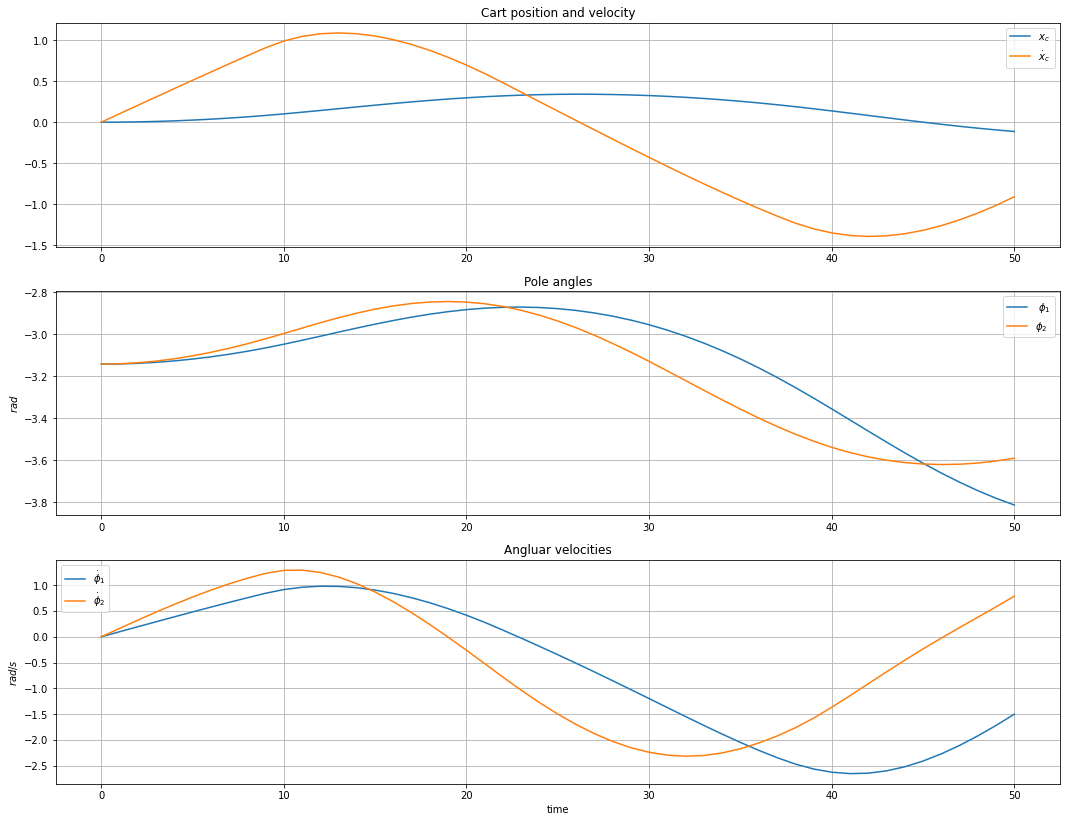

In [19]:
%matplotlib inline 
viz.plot_data(np.asarray(X_k))


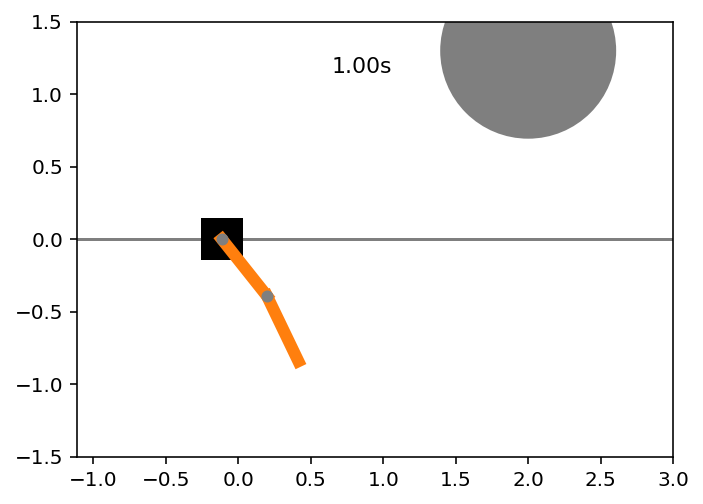

In [20]:
%matplotlib qt 
viz.simulation_viz(np.asarray(X_k), obs_pos, obs_rad)

We define target values for phi and the cart position as well as a threshold. Based on this values we will figure which solver is to be used. If following equations are fullfilled the system is expected to be in the target state. With $T$ as threshold:
\begin{align}
&| \sin(\phi_1) - \sin(\phi_{1,target}) | &\leq T \\
&| \sin(\phi_2) - \sin(\phi_{2,target}) | &\leq T \\
&| x_c - x_{c,target} | &\leq T \\
\end{align}
The accuracy can easily be varied by adjusting the threshold value.
If these equations are fullfilled the next solver can be started or the final state is reached. In our case we want to first change the solver, which has an differetn final position set. If the second target state is reached we want the mpc loop to end.


In [21]:
# Initialize result lists for states and inputs
res_x_mpc = [x_0]
res_u_mpc = []
xsoll = x_target1

first_solver = True

thres = 0.075
phi1 = np.infty
phi2 = np.infty
xc = np.infty

phi1_t = 0.0
phi2_t = 0.0 
xc_t = 0.0

In [22]:
for i in progressbar.progressbar(range(N_sim)):
    # 01 - Your code here!
    # solve optimization problem
    with io.StringIO() as buf, redirect_stdout(buf):
        mpc_res = mpc_solver(p=vertcat(x_0, xsoll), lbg=lb_g, ubg=ub_g, lbx = lb_opt_x, ubx = ub_opt_x)

        # optionally: Warmstart the optimizer by passing the previous solution as an initial guess!
        if i>0:
            mpc_res = mpc_solver(p=vertcat(x_0, xsoll), x0=opt_x_k, lbg=lb_g, ubg=ub_g, lbx = lb_opt_x, ubx = ub_opt_x)
        
        # ger stdout as string
        std_output = buf.getvalue()
        
        if "EXIT: Converged to a point of local infeasibility. Problem may be infeasible." in std_output:
            pass

    opt_x_k = opt_x(mpc_res['x'])
    u_k = opt_x_k['u',0]

    res_integrator = ode_solver(x0=x_0, p=u_k)
    x_next = res_integrator['xf']
 
    x_0 = x_next

    res_x_mpc.append(x_next)
    res_u_mpc.append(u_k)

    
    xc = x_0[0]
    phi1 = x_0[1]
    phi2 = x_0[2]
    
    # console log
    if not i % 10:
        if first_solver:
            solver = "solver 1"
        else:
            solver = "solver 2"
            
        print("\r")
        print("xc:", xc, "phi1:", phi1, "phi2", phi2, solver)

    if (abs(np.sin(0.5*phi1) - np.sin(0.5*phi1_t)) - thres <= 0 and \
                abs(np.sin(0.5*phi2) - np.sin(0.5*phi2_t)) - thres <= 0 and \
                abs(xc - xc_t) - thres <= 0):
        if first_solver:
                # activate second solver 
                first_solver = False
                xc_t = x_target2[0]
                xsoll = x_target2
                
        else:
            break

    
    
# Make an array from the list of arrays:
res_x_mpc = np.concatenate(res_x_mpc,axis=1)
res_u_mpc = np.concatenate(res_u_mpc, axis=1)

  0% (1 of 1000) |                       | Elapsed Time: 0:00:03 ETA:   0:51:16


xc: 0.00102691 phi1: -3.14062 phi2 -3.13997 solver 1


  1% (12 of 1000) |                      | Elapsed Time: 0:00:16 ETA:   0:16:30


xc: 0.122557 phi1: -3.02705 phi2 -2.96844 solver 1


  2% (22 of 1000) |                      | Elapsed Time: 0:00:28 ETA:   0:20:49


xc: 0.4215 phi1: -2.77024 phi2 -2.7047 solver 1


  3% (32 of 1000) |                      | Elapsed Time: 0:00:42 ETA:   0:24:58


xc: 0.745943 phi1: -2.59958 phi2 -2.71123 solver 1


  4% (42 of 1000) |                      | Elapsed Time: 0:00:57 ETA:   0:33:58


xc: 0.979501 phi1: -2.72164 phi2 -2.99625 solver 1


  5% (52 of 1000) |#                     | Elapsed Time: 0:01:10 ETA:   0:43:37


xc: 1.07477 phi1: -3.19993 phi2 -3.30202 solver 1


  6% (62 of 1000) |#                     | Elapsed Time: 0:01:40 ETA:   0:39:18


xc: 0.995439 phi1: -3.85429 phi2 -3.64332 solver 1


  7% (72 of 1000) |#                     | Elapsed Time: 0:02:01 ETA:   0:20:14


xc: 0.826511 phi1: -4.25565 phi2 -4.09518 solver 1


  8% (82 of 1000) |#                     | Elapsed Time: 0:02:15 ETA:   0:20:36


xc: 0.551556 phi1: -4.31766 phi2 -4.31545 solver 1


  9% (92 of 1000) |##                    | Elapsed Time: 0:02:30 ETA:   0:41:25


xc: 0.189294 phi1: -4.06783 phi2 -4.04802 solver 1


 10% (102 of 1000) |##                   | Elapsed Time: 0:02:51 ETA:   0:30:02


xc: -0.0719289 phi1: -3.43773 phi2 -3.24738 solver 1


 11% (112 of 1000) |##                   | Elapsed Time: 0:03:13 ETA:   0:22:23


xc: -0.105288 phi1: -2.39193 phi2 -2.47528 solver 1


 12% (122 of 1000) |##                   | Elapsed Time: 0:03:37 ETA:   0:34:07


xc: -0.175525 phi1: -1.60261 phi2 -2.0017 solver 1


 13% (131 of 1000) |##                   | Elapsed Time: 0:04:00 ETA:   0:48:18


xc: -0.188459 phi1: -1.30478 phi2 -1.70159 solver 1


 14% (141 of 1000) |##                   | Elapsed Time: 0:04:13 ETA:   0:12:51


xc: -0.0502071 phi1: -1.46026 phi2 -1.8357 solver 1


 15% (151 of 1000) |###                  | Elapsed Time: 0:04:32 ETA:   0:46:13


xc: 0.108392 phi1: -2.06165 phi2 -2.38422 solver 1


 16% (162 of 1000) |###                  | Elapsed Time: 0:05:08 ETA:   0:55:07


xc: 0.0683247 phi1: -3.20802 phi2 -3.10836 solver 1


 17% (171 of 1000) |###                  | Elapsed Time: 0:05:35 ETA:   0:21:42


xc: -0.122327 phi1: -4.3774 phi2 -4.34157 solver 1


 18% (182 of 1000) |###                  | Elapsed Time: 0:05:56 ETA:   0:24:57


xc: -0.243158 phi1: -5.13416 phi2 -5.25344 solver 1


 19% (191 of 1000) |####                 | Elapsed Time: 0:06:11 ETA:   0:27:15


xc: -0.288658 phi1: -5.59653 phi2 -5.6704 solver 1


 20% (202 of 1000) |####                 | Elapsed Time: 0:06:34 ETA:   0:40:58


xc: -0.218355 phi1: -5.88682 phi2 -5.9238 solver 1


 21% (212 of 1000) |####                 | Elapsed Time: 0:06:53 ETA:   0:26:37


xc: -0.0693495 phi1: -6.08651 phi2 -6.10827 solver 1


 22% (222 of 1000) |####                 | Elapsed Time: 0:07:13 ETA:   0:28:10


xc: 0.116028 phi1: -6.23776 phi2 -6.26391 solver 2


 23% (232 of 1000) |####                 | Elapsed Time: 0:07:36 ETA:   0:20:27


xc: 0.227412 phi1: -6.28956 phi2 -6.30896 solver 2


 24% (242 of 1000) |#####                | Elapsed Time: 0:07:54 ETA:   0:21:49


xc: 0.26625 phi1: -6.26562 phi2 -6.27256 solver 2


 25% (252 of 1000) |#####                | Elapsed Time: 0:08:11 ETA:   0:27:54


xc: 0.29387 phi1: -6.22123 phi2 -6.21891 solver 2


 26% (262 of 1000) |#####                | Elapsed Time: 0:08:27 ETA:   0:18:05


xc: 0.363669 phi1: -6.19492 phi2 -6.19168 solver 2


 27% (271 of 1000) |#####                | Elapsed Time: 0:08:40 ETA:   0:20:21


xc: 0.481355 phi1: -6.18263 phi2 -6.18047 solver 2


 28% (282 of 1000) |#####                | Elapsed Time: 0:09:04 ETA:   0:26:53


xc: 0.634959 phi1: -6.16789 phi2 -6.15949 solver 2


 29% (292 of 1000) |######               | Elapsed Time: 0:09:24 ETA:   0:24:26


xc: 0.841872 phi1: -6.16434 phi2 -6.13186 solver 2


 30% (301 of 1000) |######               | Elapsed Time: 0:10:07 ETA:   1:09:22


xc: 1.22872 phi1: -6.30252 phi2 -6.26558 solver 2


 31% (312 of 1000) |######               | Elapsed Time: 0:10:54 ETA:   0:35:55


xc: 1.82121 phi1: -6.65846 phi2 -6.69528 solver 2


 32% (321 of 1000) |######               | Elapsed Time: 0:11:36 ETA:   1:03:51


xc: 2.4973 phi1: -7.24033 phi2 -7.52934 solver 2


 33% (331 of 1000) |######               | Elapsed Time: 0:12:27 ETA:   1:12:49


xc: 2.97252 phi1: -8.10457 phi2 -8.62682 solver 2


 34% (342 of 1000) |#######              | Elapsed Time: 0:14:06 ETA:   2:24:05


xc: 3.20063 phi1: -9.64988 phi2 -9.34654 solver 2


 35% (351 of 1000) |#######              | Elapsed Time: 0:14:59 ETA:   1:16:30


xc: 3.42549 phi1: -10.8748 phi2 -10.9888 solver 2


 36% (362 of 1000) |#######              | Elapsed Time: 0:16:05 ETA:   0:50:23


xc: 3.75502 phi1: -11.6852 phi2 -12.0709 solver 2


 37% (371 of 1000) |#######              | Elapsed Time: 0:16:40 ETA:   0:39:00


xc: 3.94051 phi1: -12.1798 phi2 -12.3712 solver 2


 38% (381 of 1000) |########             | Elapsed Time: 0:17:26 ETA:   1:08:55


xc: 4.01023 phi1: -12.3909 phi2 -12.4562 solver 2


 38% (382 of 1000) |########             | Elapsed Time: 0:17:31 ETA:   0:48:22

When the mpc loop is finished and the results are saved in a suitable format, we can visualize them using our visualilzer class.

In [24]:
%matplotlib qt
viz.simulation_viz(res_x_mpc, obs_pos, obs_rad, res_u_mpc)

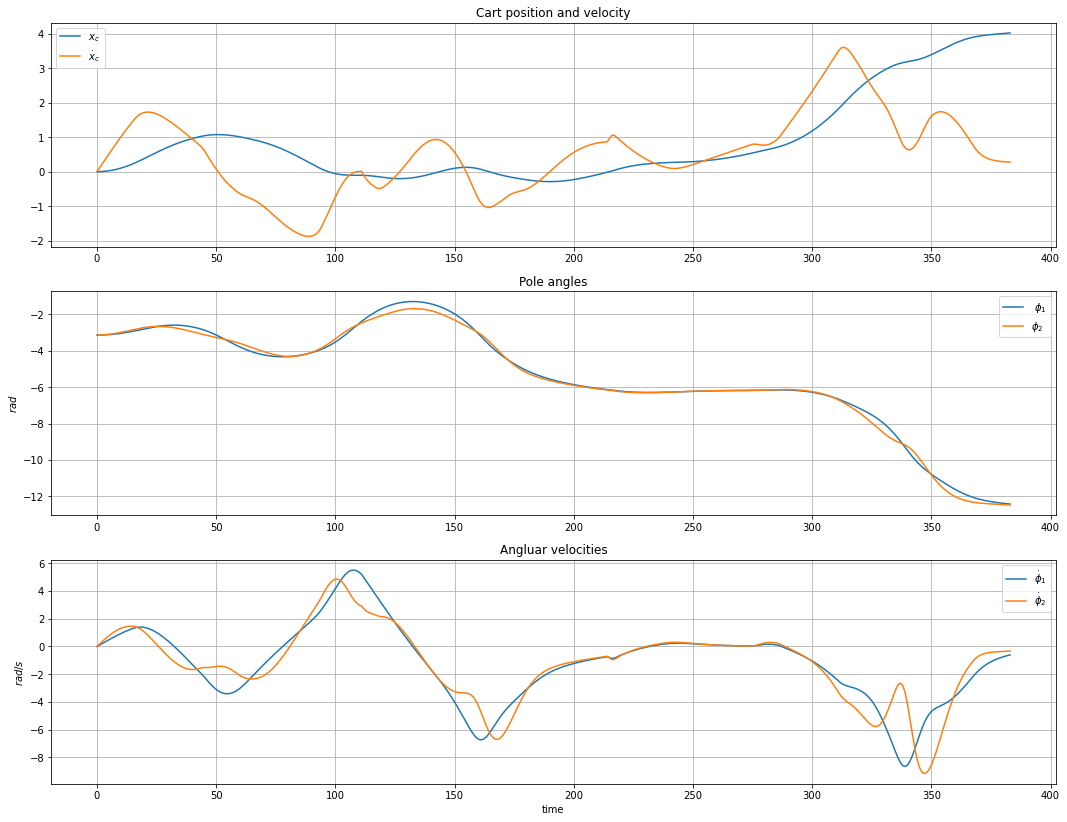

In [25]:
%matplotlib inline
viz.plot_data(res_x_mpc)

In [ ]:
# Backup states and inputs for plotting 
with open('obstacle_states2.npy', 'wb') as f:
    np.save(f, res_x_mpc)
    
with open('obstacle_inputs2.npy', 'wb') as f:
    np.save(f, res_u_mpc)